In [2]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter
import os
import json

### Prepare the Network and Data

We import all the json files we created in the data fetching part intoa single dictionary called 'all_data', and access each specific json fuile by using their file name as the first key of the dictionary.

In [3]:
data_folder_path = '../data/'

all_data = {}
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        json_file_path = os.path.join(data_folder_path, filename)
        
        with open(json_file_path, 'r') as file:
            all_data[os.path.splitext(filename)[0]] = json.load(file)

And build the cumulative character co-occurance networks for each episode:

In [4]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    """
    Create a character interaction graph(s) from episode data.

    Parameters:
    - data (dict): Dictionary containing episode data, where keys are season names
                  and values are lists of episode data dictionaries.
    - season (str): If specified, create a character interaction graph for the given season.
                   If None, create graphs for all seasons in the data.
    - characters_info (dict): Dictionary with character attributes to add as node attributes.

    Returns:
    - graph_dict (dict): Dictionary where keys are graph labels (e.g., 'G1') and values
                        are corresponding networkx.Graph instances representing character
                        interaction graphs.
    """

    graph_dict = {} 
    count = 1  

    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  
                characters = episodes_data[i]["Characters"] 

                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  

                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                if characters is not None: 
                    G.add_nodes_from(characters)  

                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  
                count += 1  
    
    else:
        season_data = data[season]  
        graph_dict = {}  
        count = 1  

        for i in range(len(season_data)):
            G = nx.Graph()  
            characters = season_data[i]["Characters"] 

            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  
                
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            if characters is not None:  
                G.add_nodes_from(characters) 

                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  
            count += 1 

    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict

def add_node_attributes(graph, attributes_dict):
    """
    Add node attributes to a graph based on a dictionary.

    Parameters:
    - graph (networkx.Graph): The graph to which attributes will be added.
    - attributes_dict (dict): Dictionary where keys are node names and values are
                              dictionaries containing node attributes.
    """
    
    for node, attributes in attributes_dict.items():
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [5]:
def filter_edges_below_threshold(cumulative_graph, final_graph, threshold):

    """
    Filter edges below a given threshold in a cumulative graph based on final graph weights.

    Parameters:
    - cumulative_graph (networkx.Graph): The cumulative graph containing edges with weights.
    - final_graph (networkx.Graph): The final graph used to determine edge weights.
    - threshold (float): The threshold value below which edges will be removed.

    Returns:
    - filtered_graph (networkx.Graph): A filtered graph with edges above the specified threshold.
    """

    filtered_graph = cumulative_graph.copy()

    # Iterate through edges and remove those below the threshold in the final graph (G1013)
    edges_to_remove = [(u, v) for u, v, w in cumulative_graph.edges(data='weight') if final_graph[u][v]['weight'] < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

The following dictionary consists of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.

In [6]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=all_data['characters_infobox'])

In [7]:
len(graph_dict_all_seasons['G1013'].edges)

21576

In [9]:
# The five great nations
five_great_node_dict = {
    "Konohagakure": "red", 
    "Sunagakure": "green",      
    "Kirigakure": "blue",
    "Kumogakure": "yellow",
    "Iwagakure": "#8B4513",
    "default": "black"
}

five_great_edges_dict = {
    "Konohagakure-Konohagakure": "red", 
    "Sunagakure-Sunagakure": "green", 
    "Kirigakure-Kirigakure": "blue", 
    "Kumogakure-Kumogakure": "yellow",
    "Iwagakure-Iwagakure": "#8B4513",
    "default": "gray"
}

id_color_dict = {"Konohagakure": "Red", "Sunagakure": "Green", "Kirigakure": "Blue", "Kumogakure": "Yellow", "Iwagakure": "Brown", "Remaining villages": "Black"}


In [10]:
def color_nodes_by_affiliation(G, node_colors_dict):
    """
    Color nodes in the graph based on their affiliation.

    Parameters:
    - G: NetworkX graph
    - node_colors_dict: Dictionary mapping village names to colors

    Returns:
    - List of node colors
    """
    node_colors = []
    for node in G.nodes:
        affiliation = G.nodes[node].get('Affiliation', [])

        if affiliation:
            for village in affiliation:
                if village in node_colors_dict:
                    node_colors.append(node_colors_dict[village])
                    break  
            else:
                node_colors.append(node_colors_dict["default"])  
        else:
            node_colors.append(node_colors_dict["default"])

    return node_colors


def color_edges_by_affiliation(G, edge_colors_dict):
    """
    Color edges in the graph based on the affiliation of their nodes.

    Parameters:
    - G: NetworkX graph
    - edge_colors_dict: Dictionary mapping village names to edge colors

    Returns:
    - List of edge colors
    """
    edge_colors = []
    for edge in G.edges:
        node1, node2 = edge
        affiliation1 = G.nodes[node1].get('Affiliation', [])
        affiliation2 = G.nodes[node2].get('Affiliation', [])

        if affiliation1 and affiliation2:
            common_affiliation = set(affiliation1) & set(affiliation2)
            if common_affiliation:
                for village in common_affiliation:
                    edge_key = f"{village}-{village}"
                    if edge_key in edge_colors_dict:
                        edge_colors.append(edge_colors_dict[edge_key])
                        break  
                else:
                    edge_colors.append(edge_colors_dict["default"])  
            else:
                edge_colors.append(edge_colors_dict["default"])  
        else:
            edge_colors.append(edge_colors_dict["default"]) 

    return edge_colors

In [11]:
def plot_graph(graph, layout='spring', figsize=(12, 18), with_labels=True):
    """
    Plot a network graph with various layout options.

    Parameters:
    - graph (networkx.Graph): The graph to be plotted.
    - layout (str): Layout algorithm for node positioning. Options: 'spring', 'kamada-kawai', 'spectral'.
                    Default is 'spring'.
    - figsize (tuple): Figure size in inches. Default is (12, 18).
    - with_labels (bool): Whether to include node labels in the plot. Default is True.
    """

    node_degrees = dict(graph.degree())
    node_sizes = [deg * 30 for deg in node_degrees.values()]

    node_colors = color_nodes_by_affiliation(graph, five_great_node_dict)
    edge_colors = color_edges_by_affiliation(graph, five_great_edges_dict)

    if layout=='spring':
        pos = nx.spring_layout(graph, scale=8.0) 
    elif layout=='kamada-kawai':
        pos= nx.kamada_kawai_layout(graph)
    elif layout=='spectral':
        pos = nx.spectral_layout(graph)

    plt.figure(figsize=figsize)
    nx.draw(graph, pos, node_size=node_sizes, node_color=node_colors, edge_color=edge_colors, width=0.1, with_labels=with_labels)

    plt.show()

### Development of the Series w.r.t. a fixed Threshold

We first filter out the nodes and edges that are below the chosen threshold from the graphs we are going to analyze: 

In [12]:
episode_graphs_list = ['G1', 'G20', 'G100', 'G220', 'G720', 'G1013']
#episode_graphs_list = list(graph_dict_all_seasons.keys())
threshold = 100

filtered_graphs = {}
for episode in episode_graphs_list:
    filtered_graphs[episode] = filter_edges_below_threshold(graph_dict_all_seasons[episode], graph_dict_all_seasons['G1013'], threshold)

#### Up to Episode 1

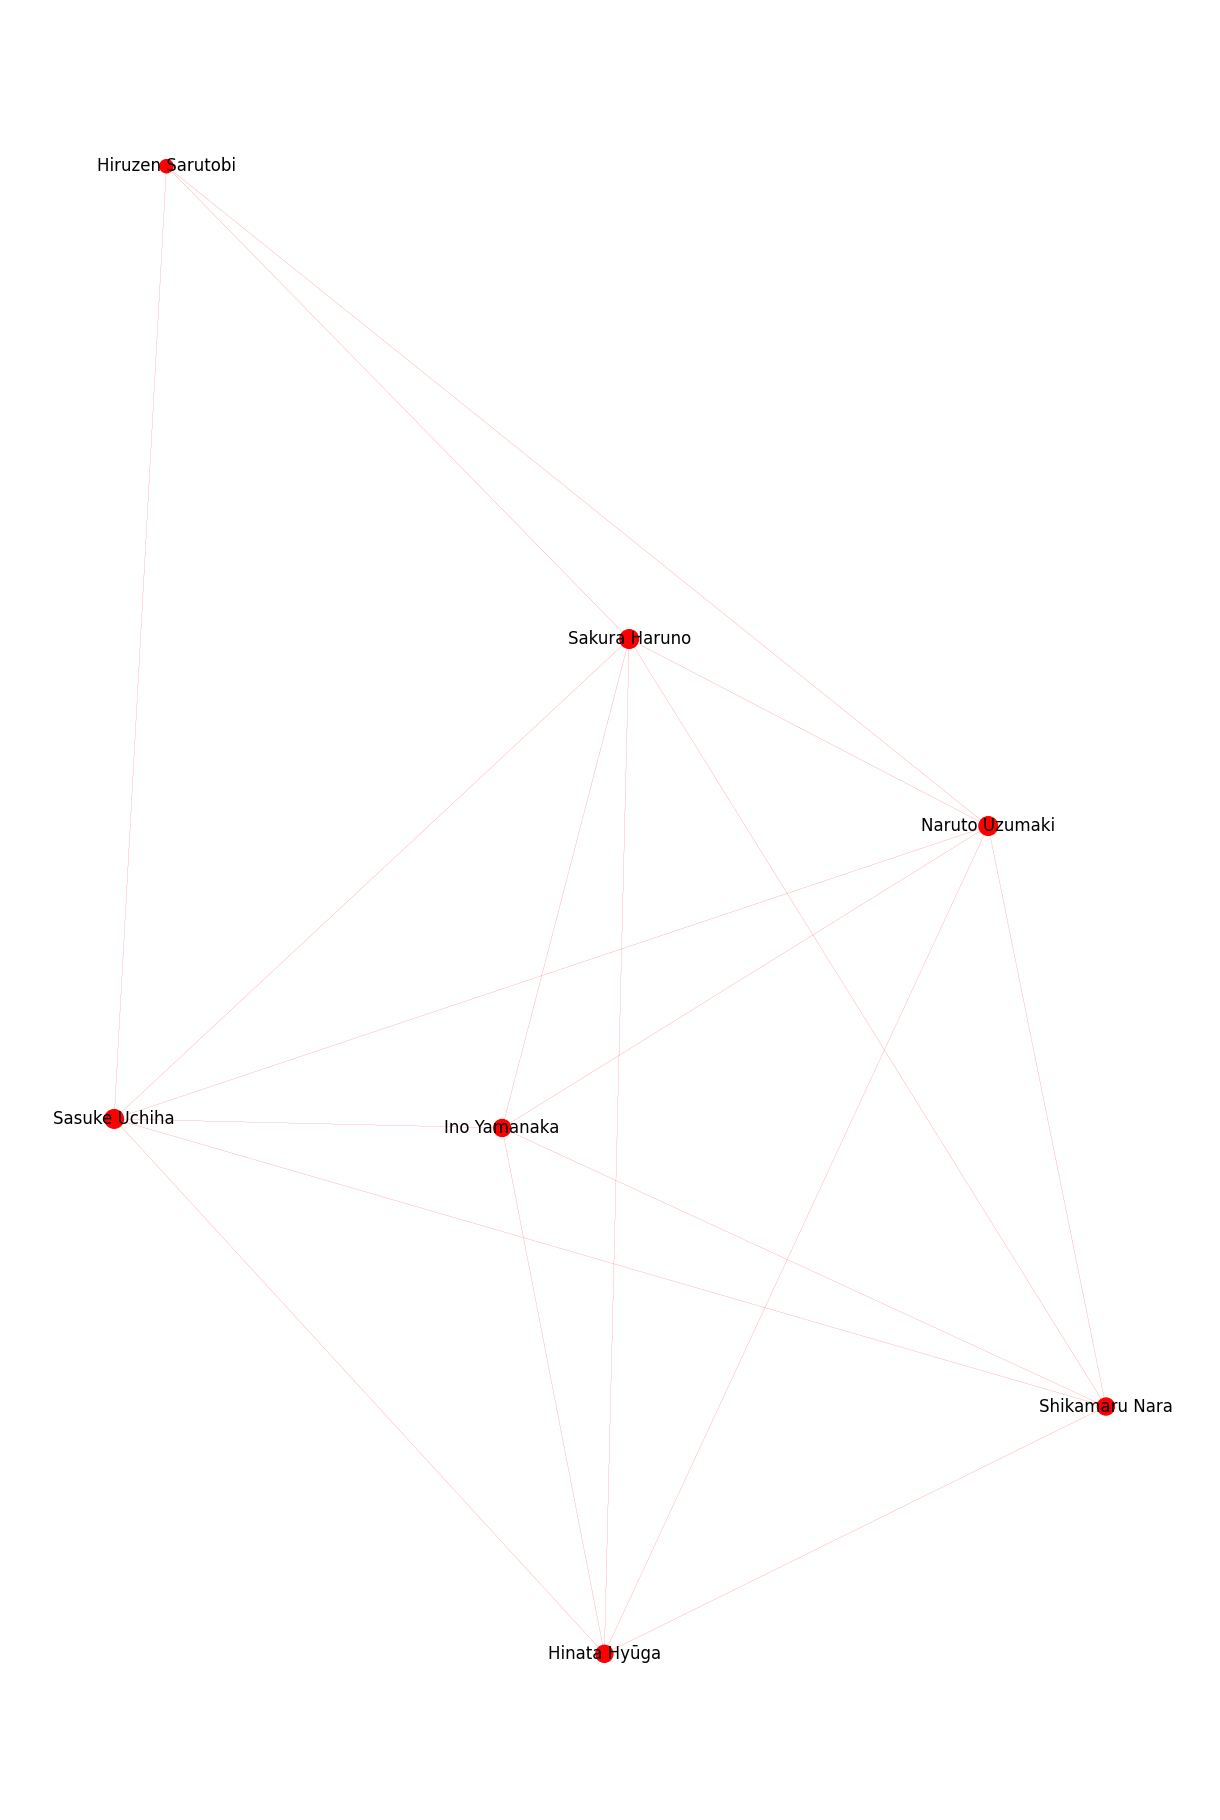

In [13]:
plot_graph(filtered_graphs['G1'])

#### Up to Episode 20

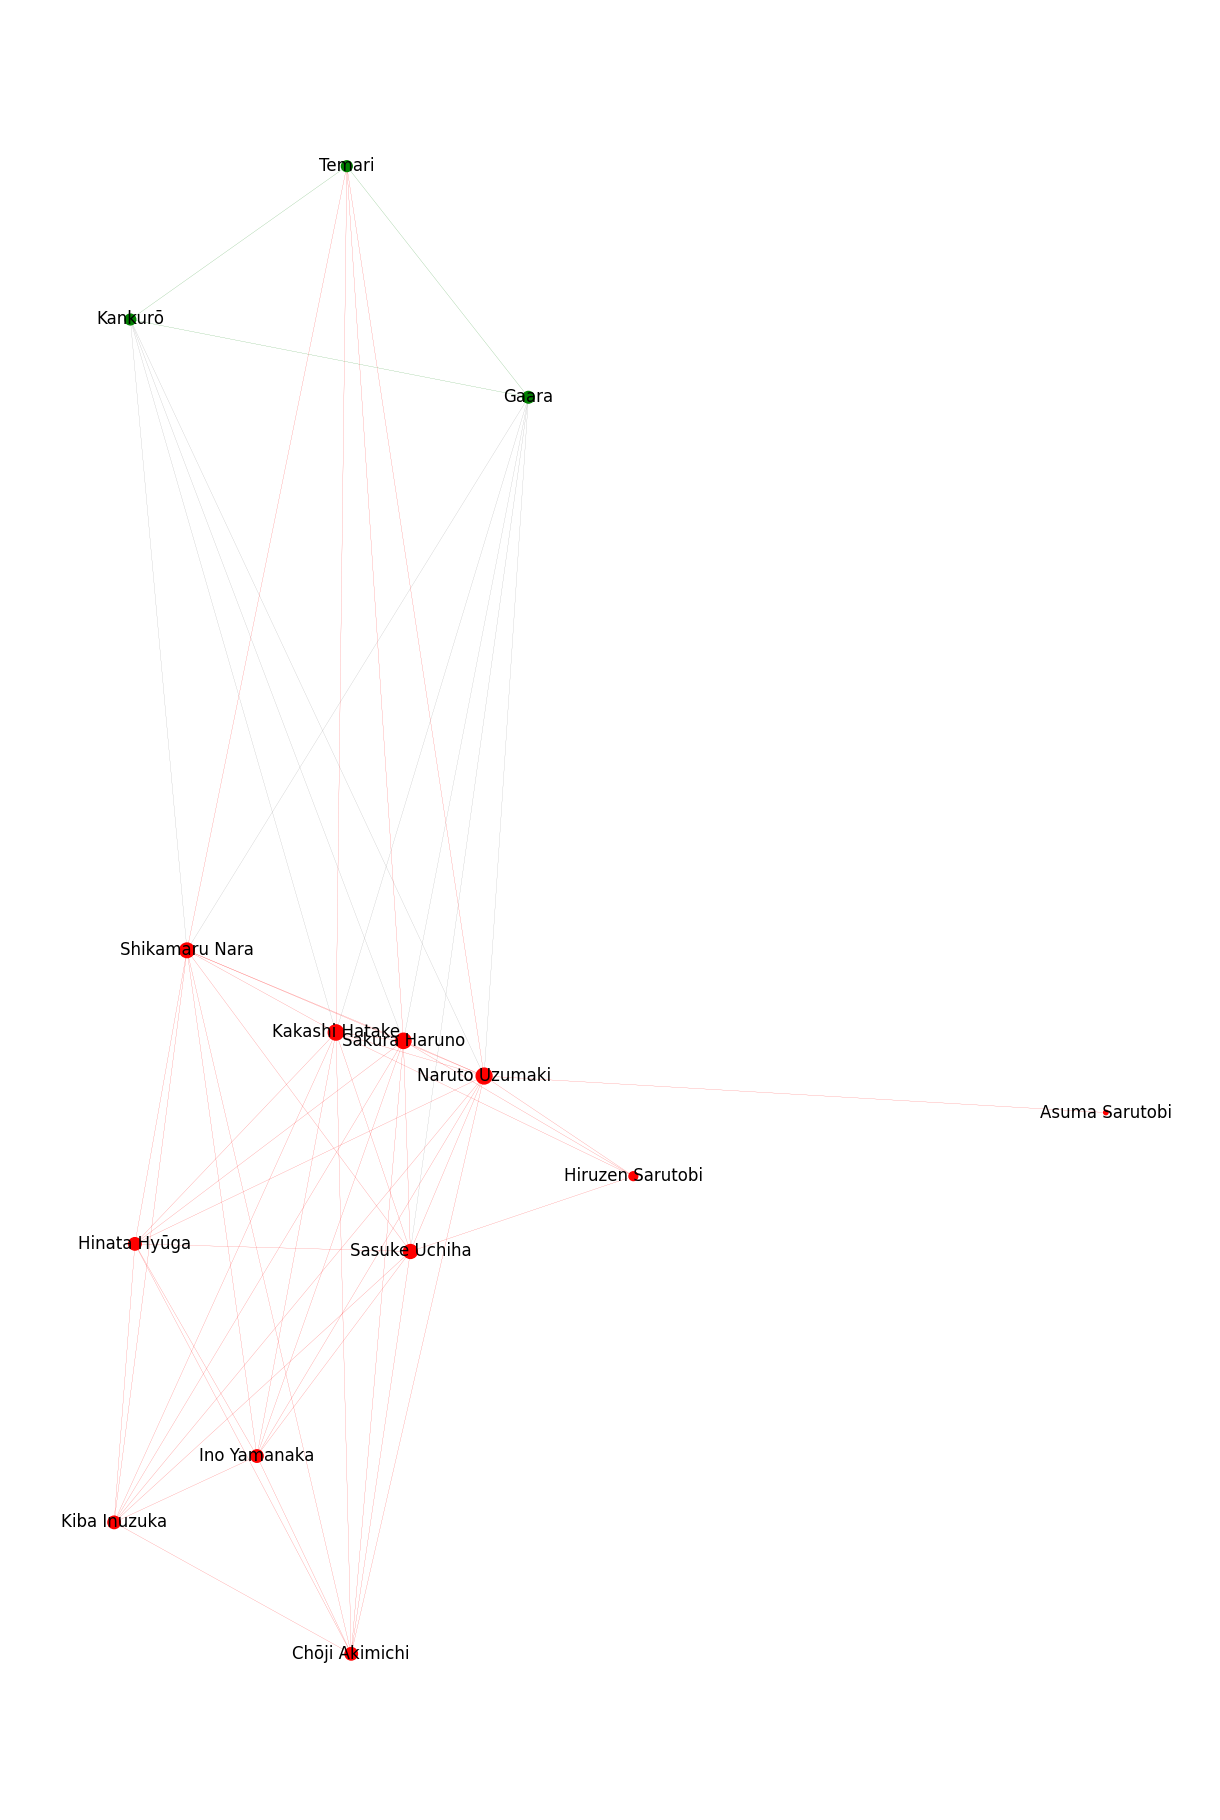

In [18]:
plot_graph(filtered_graphs['G20'])

#### Up to Episode 100

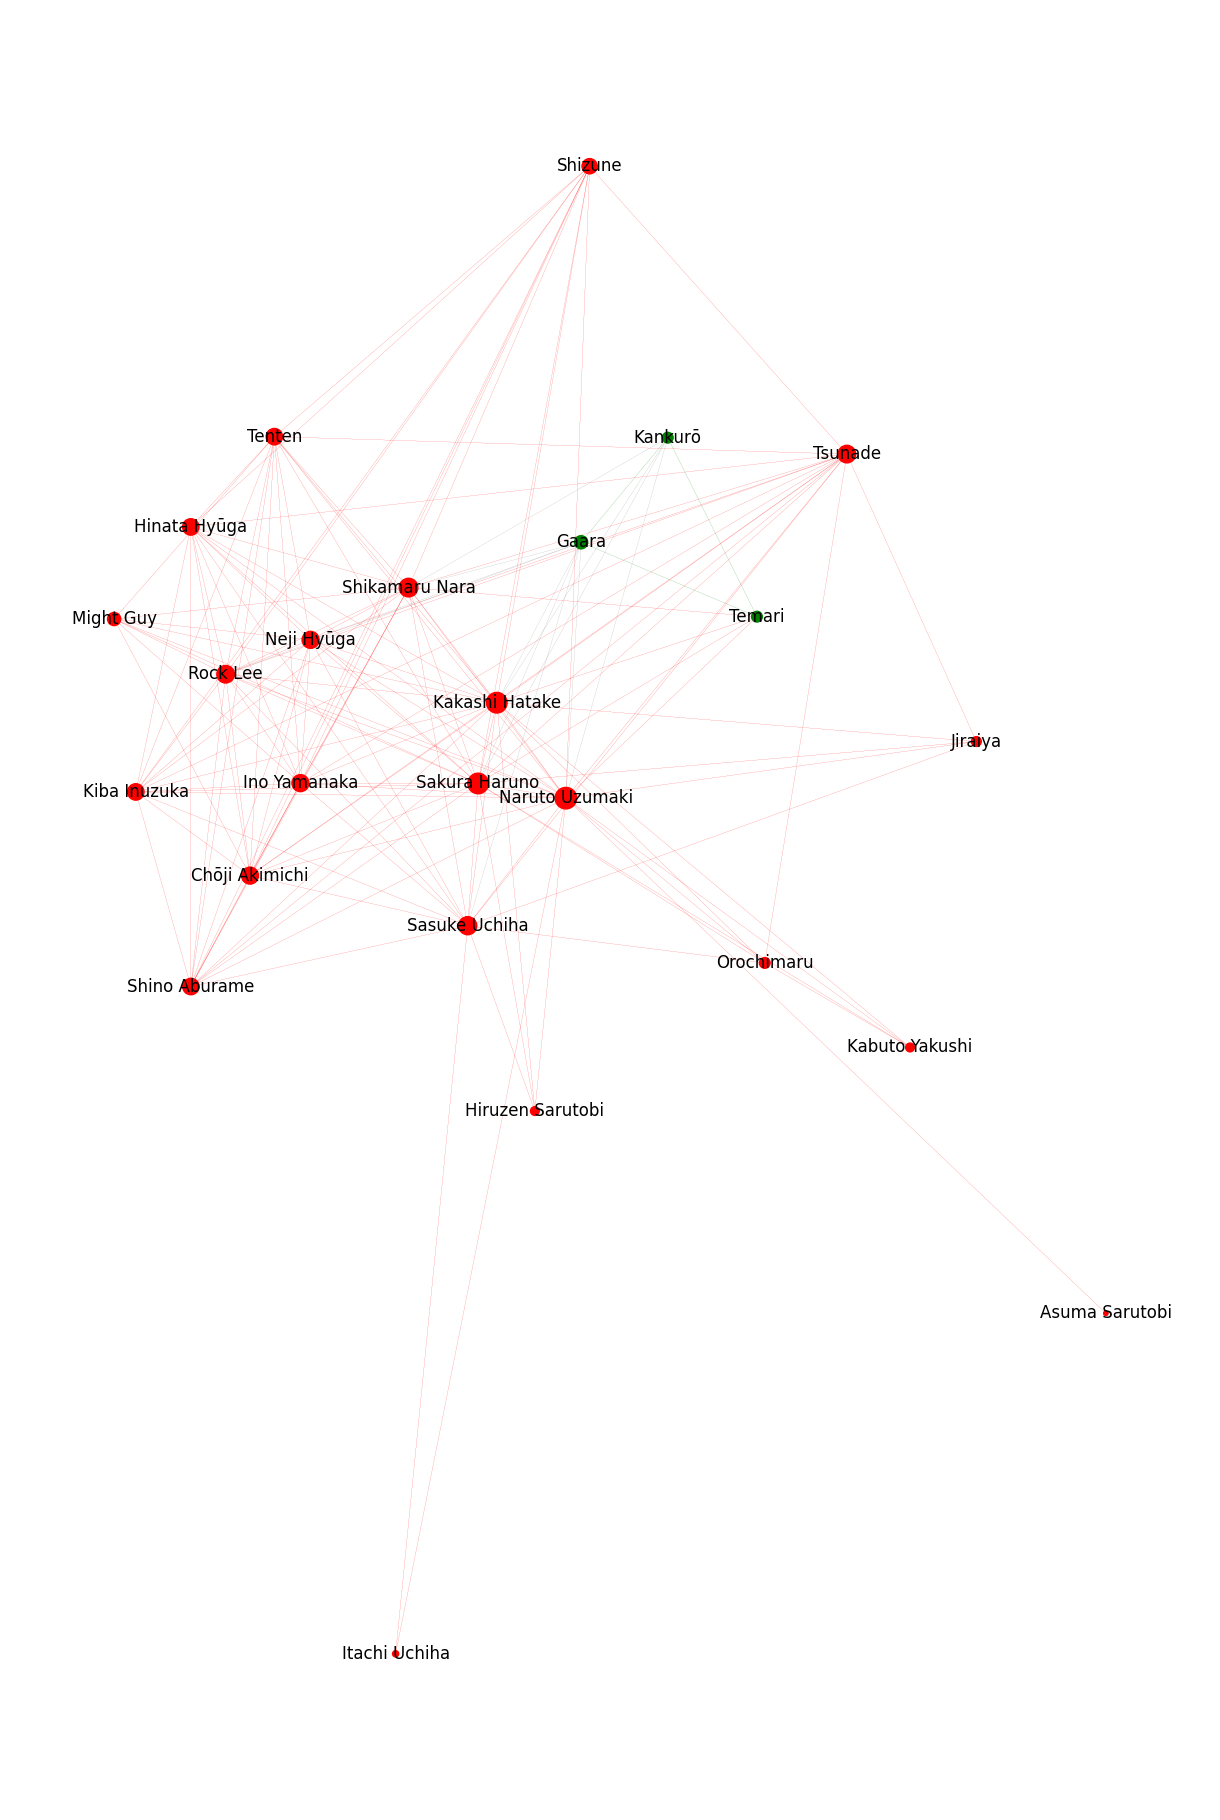

In [44]:
plot_graph(filtered_graphs['G100'])

#### Up to Episode 220 (Last Episode of season 1)

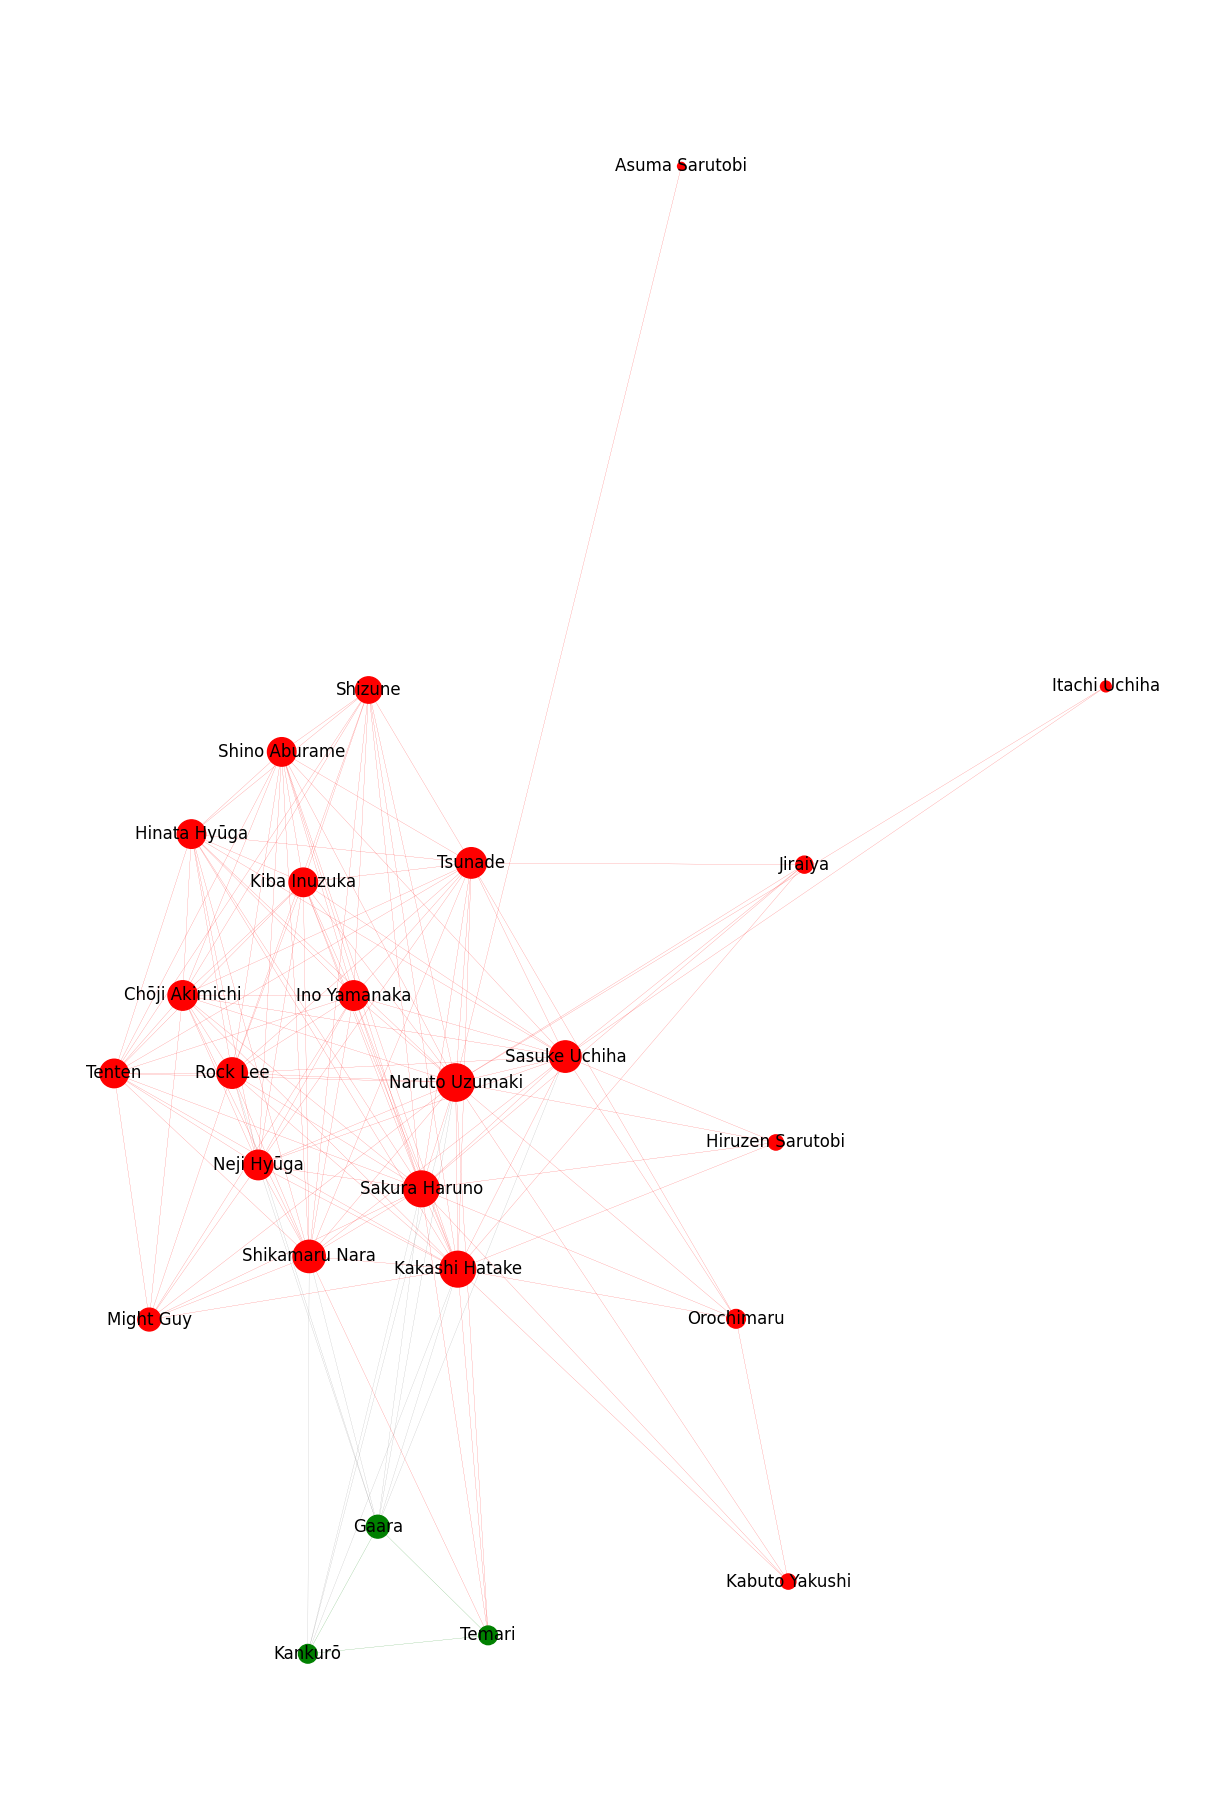

In [14]:
plot_graph(filtered_graphs['G220'])

#### Up to Episode 720 (Last Episode of season 2)

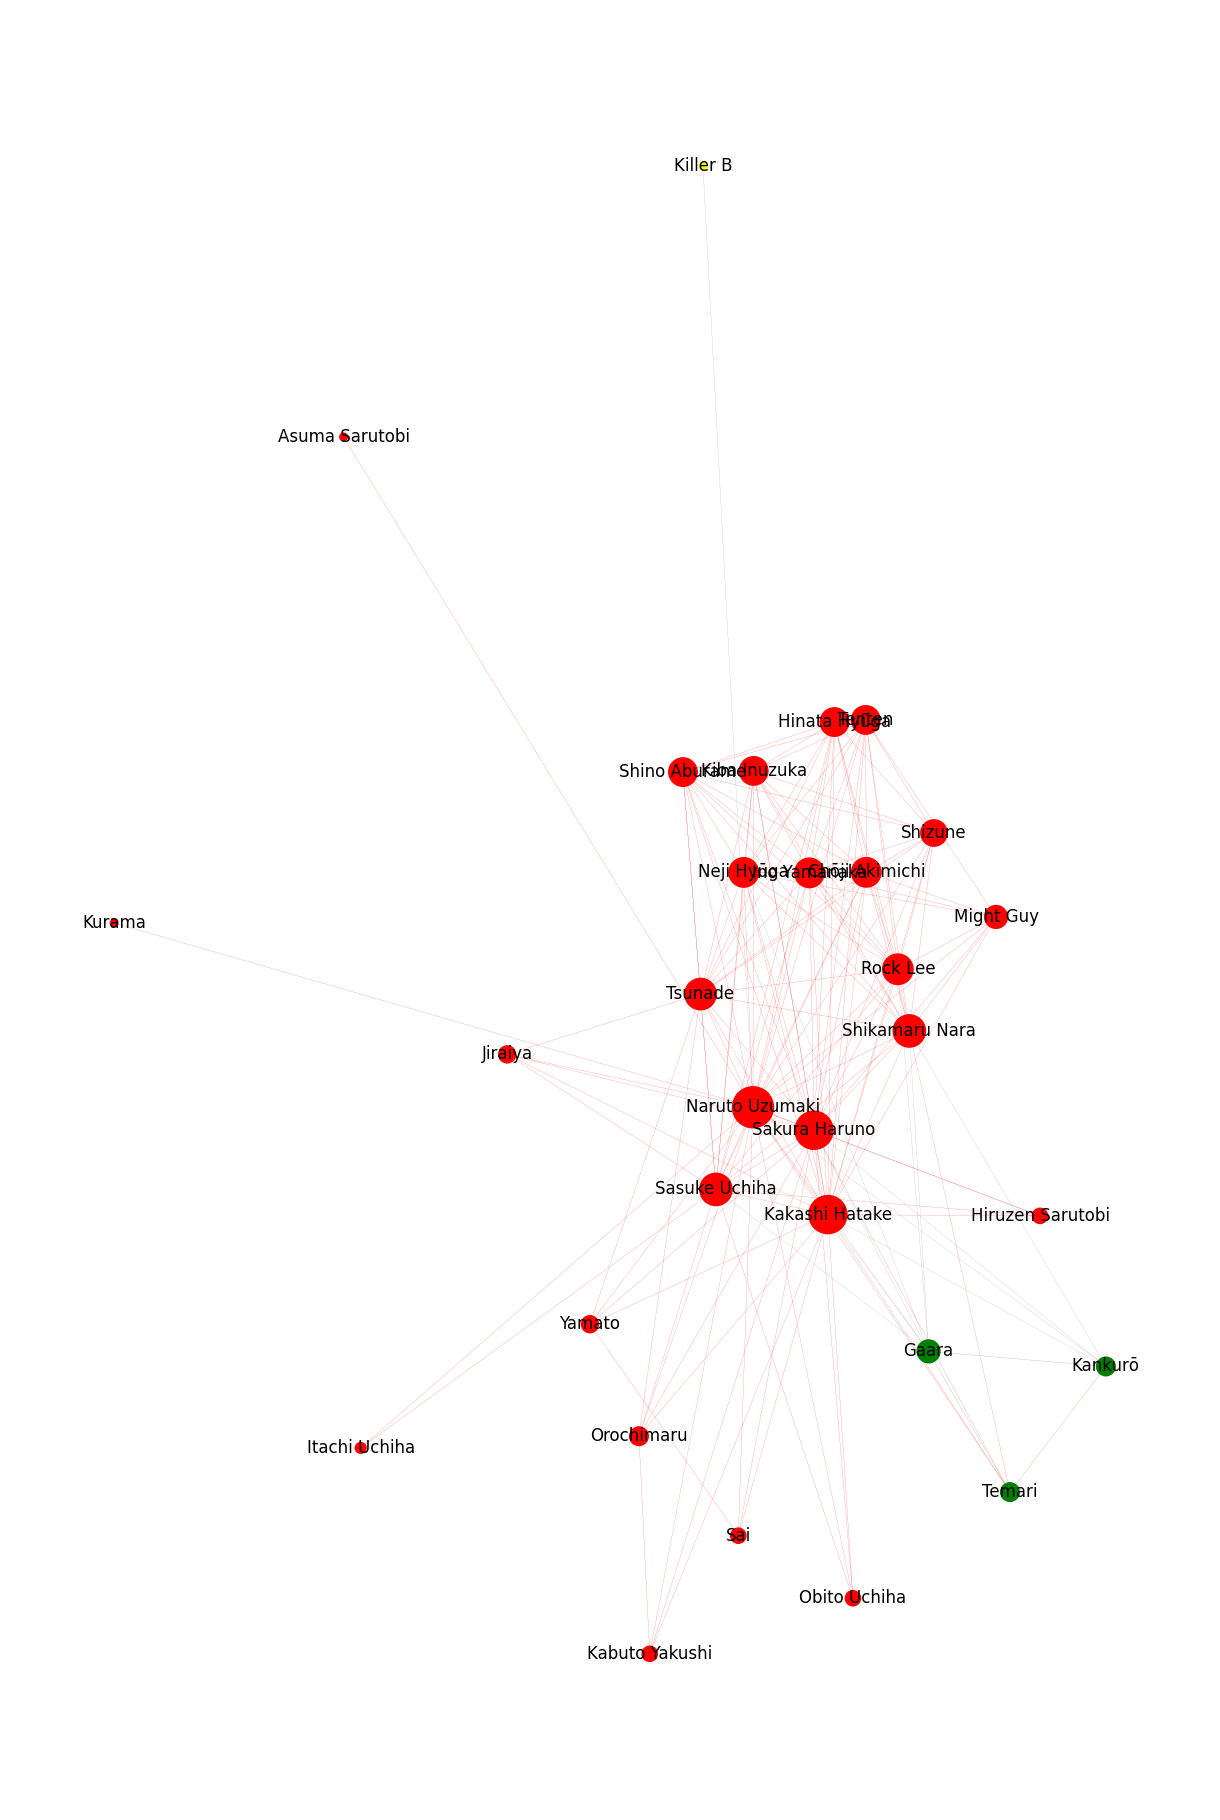

In [15]:
plot_graph(filtered_graphs['G720'])

#### Up to Episode 1013 (Final Episode of the series)

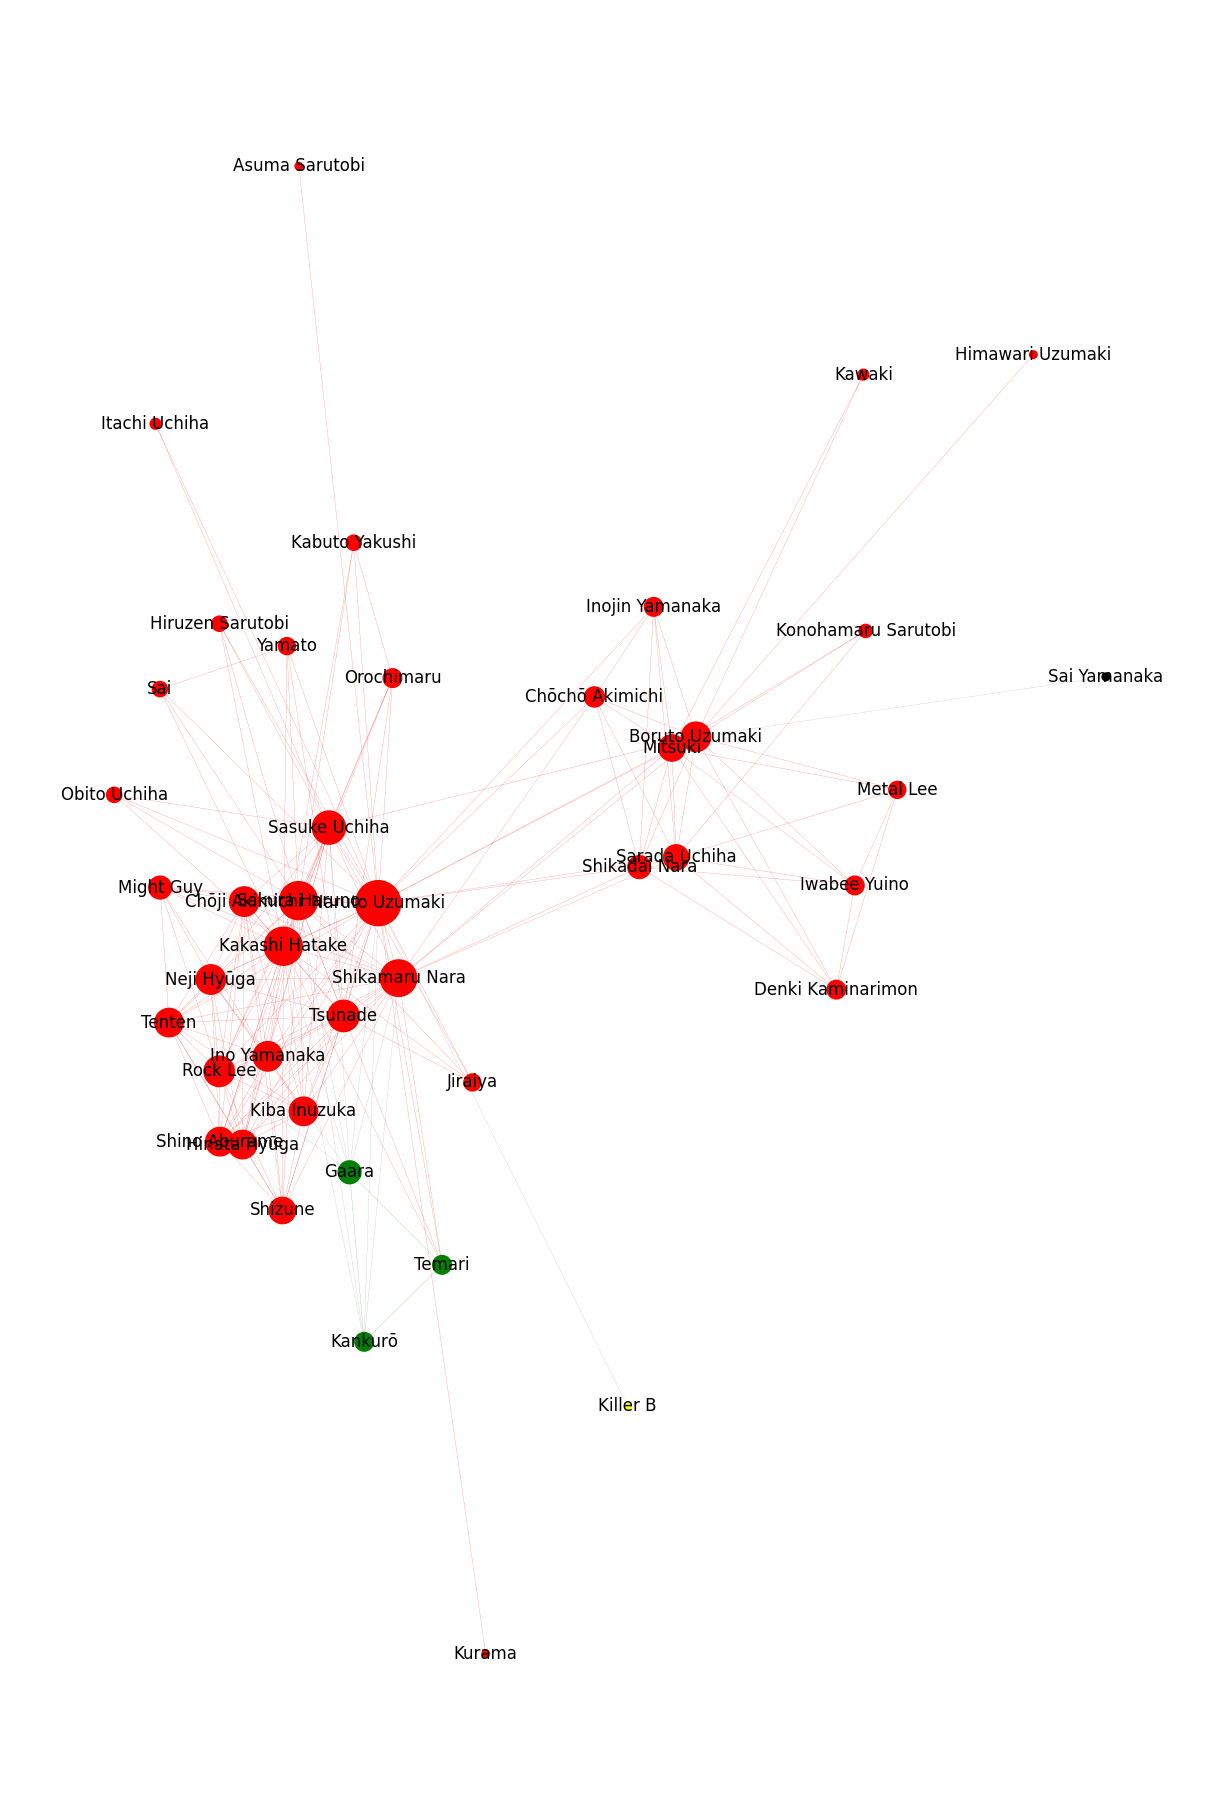

In [16]:
plot_graph(filtered_graphs['G1013'])

### Analyzing Average Edge Weights over Time

As mentioned earlier, edge weights are the number of co-occurences of two characters throughout the series. 

We were curious about whether we were going to observe any irregularities about the development of average edge weight of each episode graph. Our a-priori expectation is that, since the episode graphs are cumulative, to observe a monotonically increasing trend. 

In [12]:

average_edge_weights_over_time = []

for episode_graph in list(filtered_graphs.values()):
    all_edge_weights = [weight['weight'] for _, _, weight in episode_graph.edges(data=True)]
    average_edge_weight = np.mean(all_edge_weights)

    average_edge_weights_over_time.append(average_edge_weight)


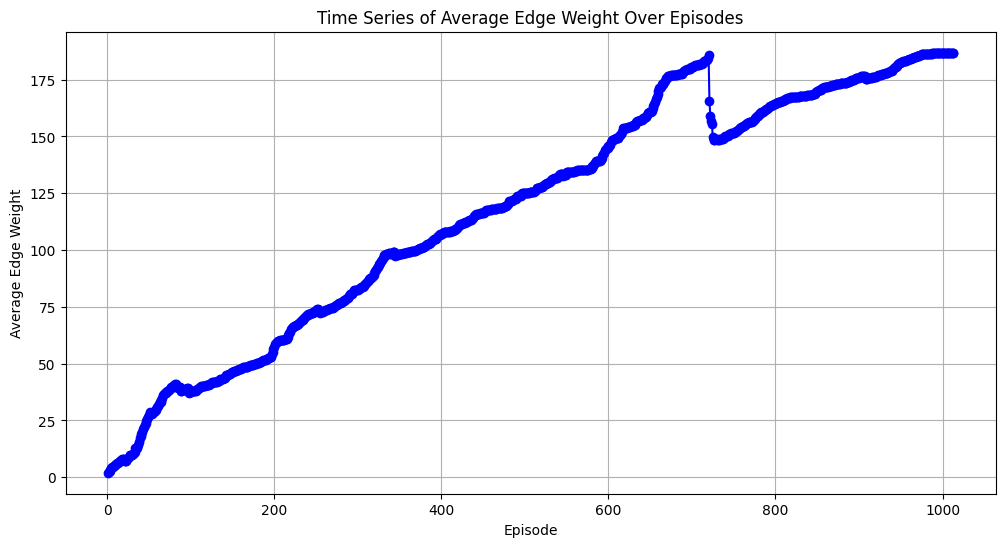

In [13]:
# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(graph_dict_all_seasons) + 1), average_edge_weights_over_time, marker='o', linestyle='-', color='b')
plt.title('Time Series of Average Edge Weight Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Edge Weight')
plt.grid(True)
plt.show()

The plot shows an almost monotonic increase in the average edge weights, with a couple of stagnant points and one significant decrease in the average edge weights. This significant decrease corresponds to the start of the Season 3, where the narrative completely shifts into a different path, and a lot of new important characters start top occur. At the point where these new characters are introduced, their edge weights are naturally low, and decreases the overall average edge weight of the network, and with the time we observe the usual increase in the edge weights again, as more and more newly introduced characters start to connect with each other

### Analysis of the Complete Network w.r.t. Changing Thresholds

By conducting this analysis, we want to observe the most important characters in the series by slowly increasing the minimum co-occurence threshold. 

We start by defining the thresholds and filtering the the final episode's network w.r.t. the chosen thresholds:

In [48]:
G1013 = graph_dict_all_seasons['G1013']
thresholds = [10, 50, 100, 200, 500]

filtered_complete_graph = {}
for threshold in thresholds:
    filtered_complete_graph[f"Min Co-occurence: {threshold}"] = filter_edges_below_threshold(G1013, G1013, threshold)

#### Network of the Final Episode with a Minimum Co-Occurence Treshold: 10

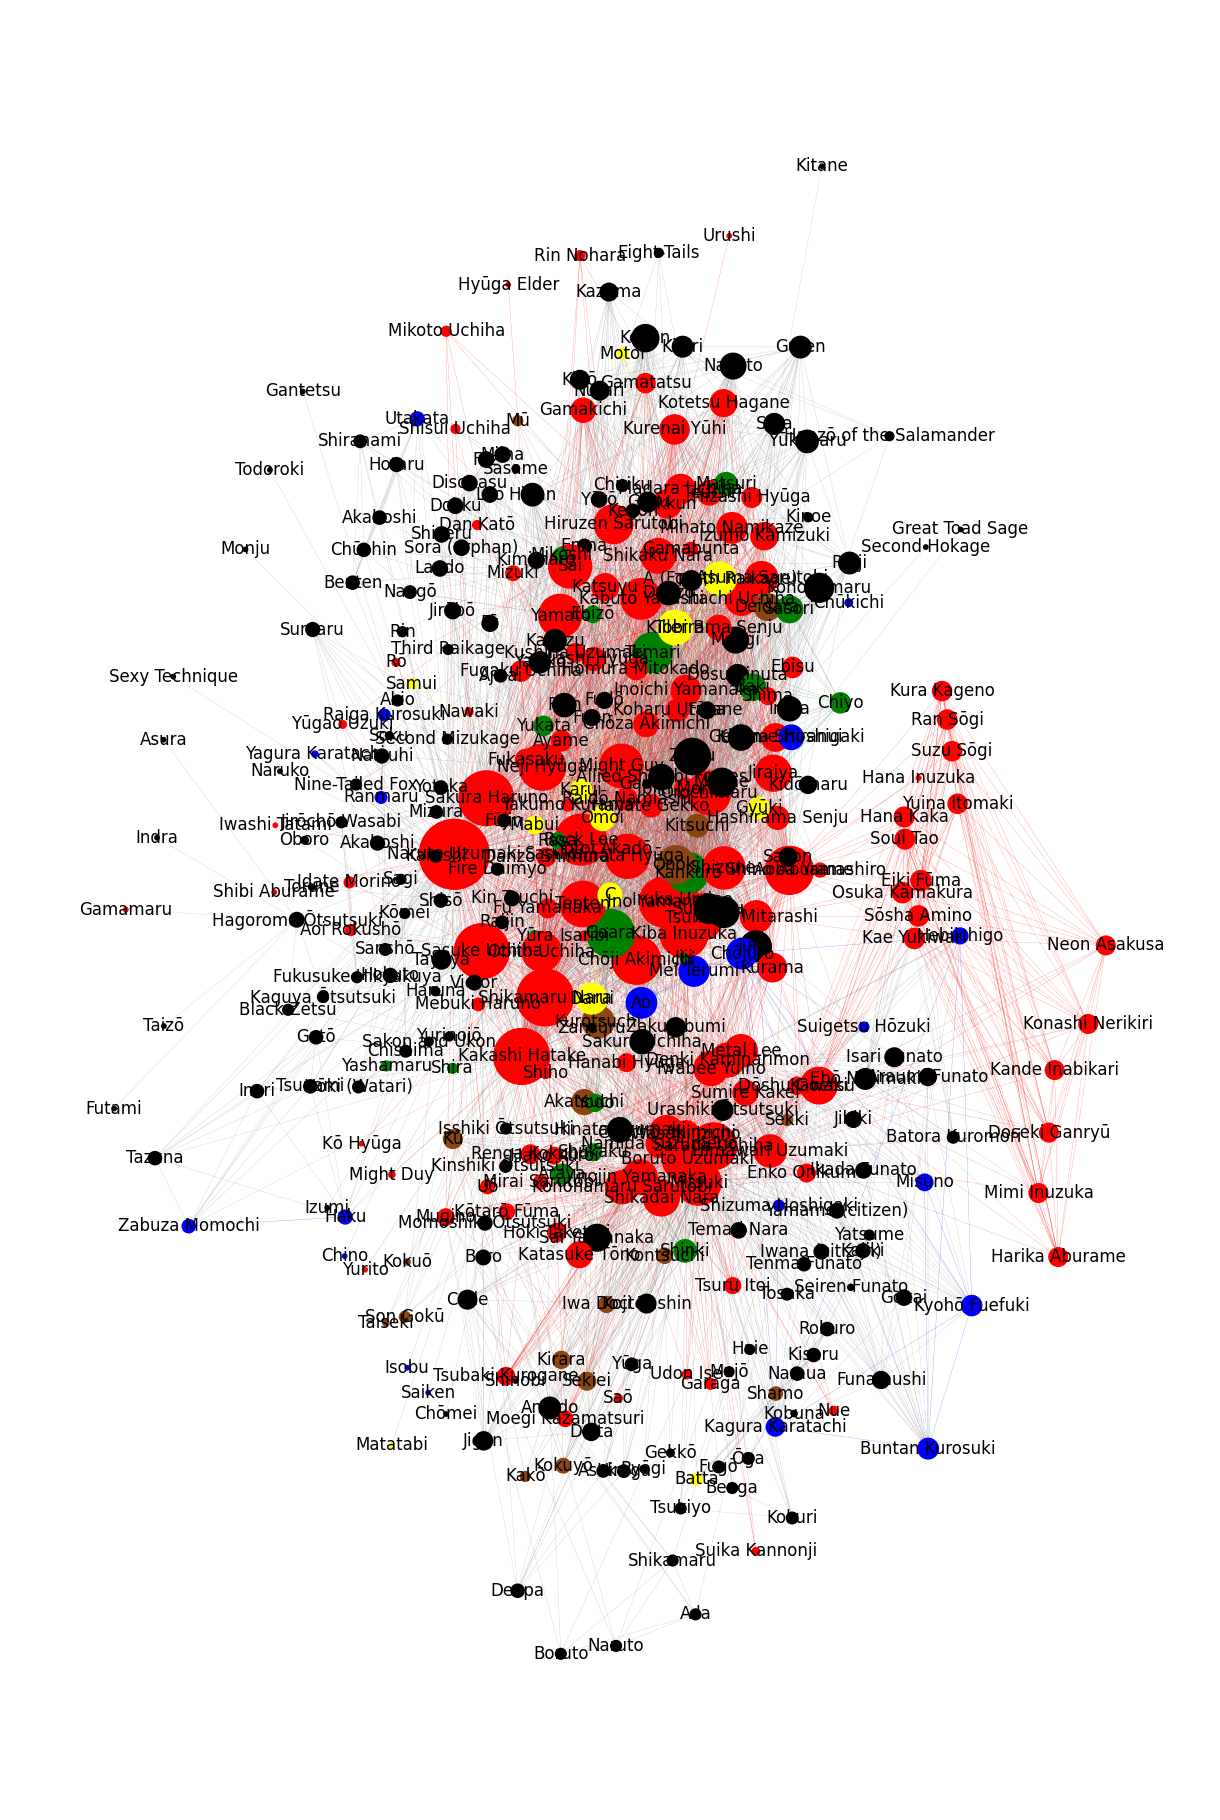

In [58]:
plot_graph(filtered_complete_graph['Min Co-occurence: 10'], layout='kamada-kawai')

#### Network of the Final Episode with a Minimum Co-Occurence Treshold: 50

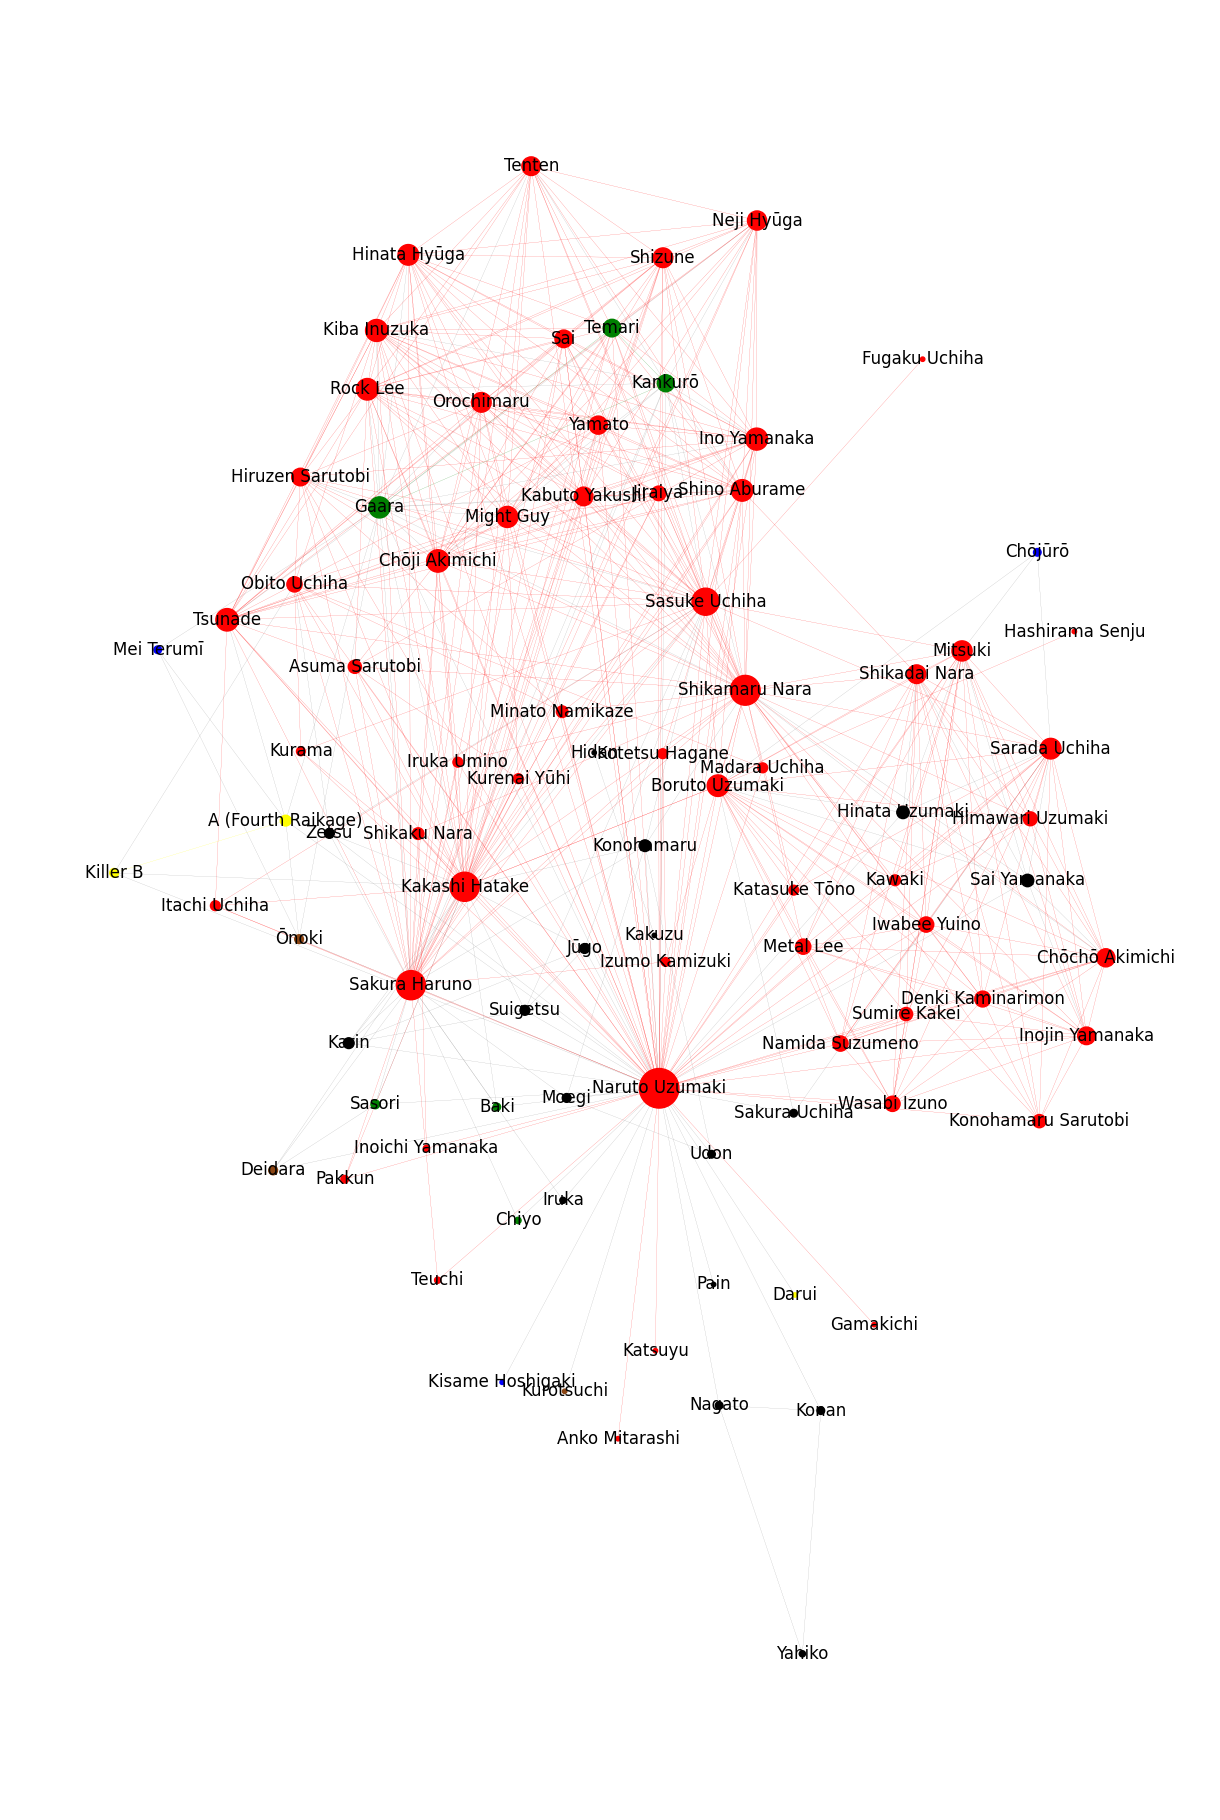

In [57]:
plot_graph(filtered_complete_graph['Min Co-occurence: 50'], layout='kamada-kawai')

#### Network of the Final Episode with a Minimum Co-Occurence Treshold: 100

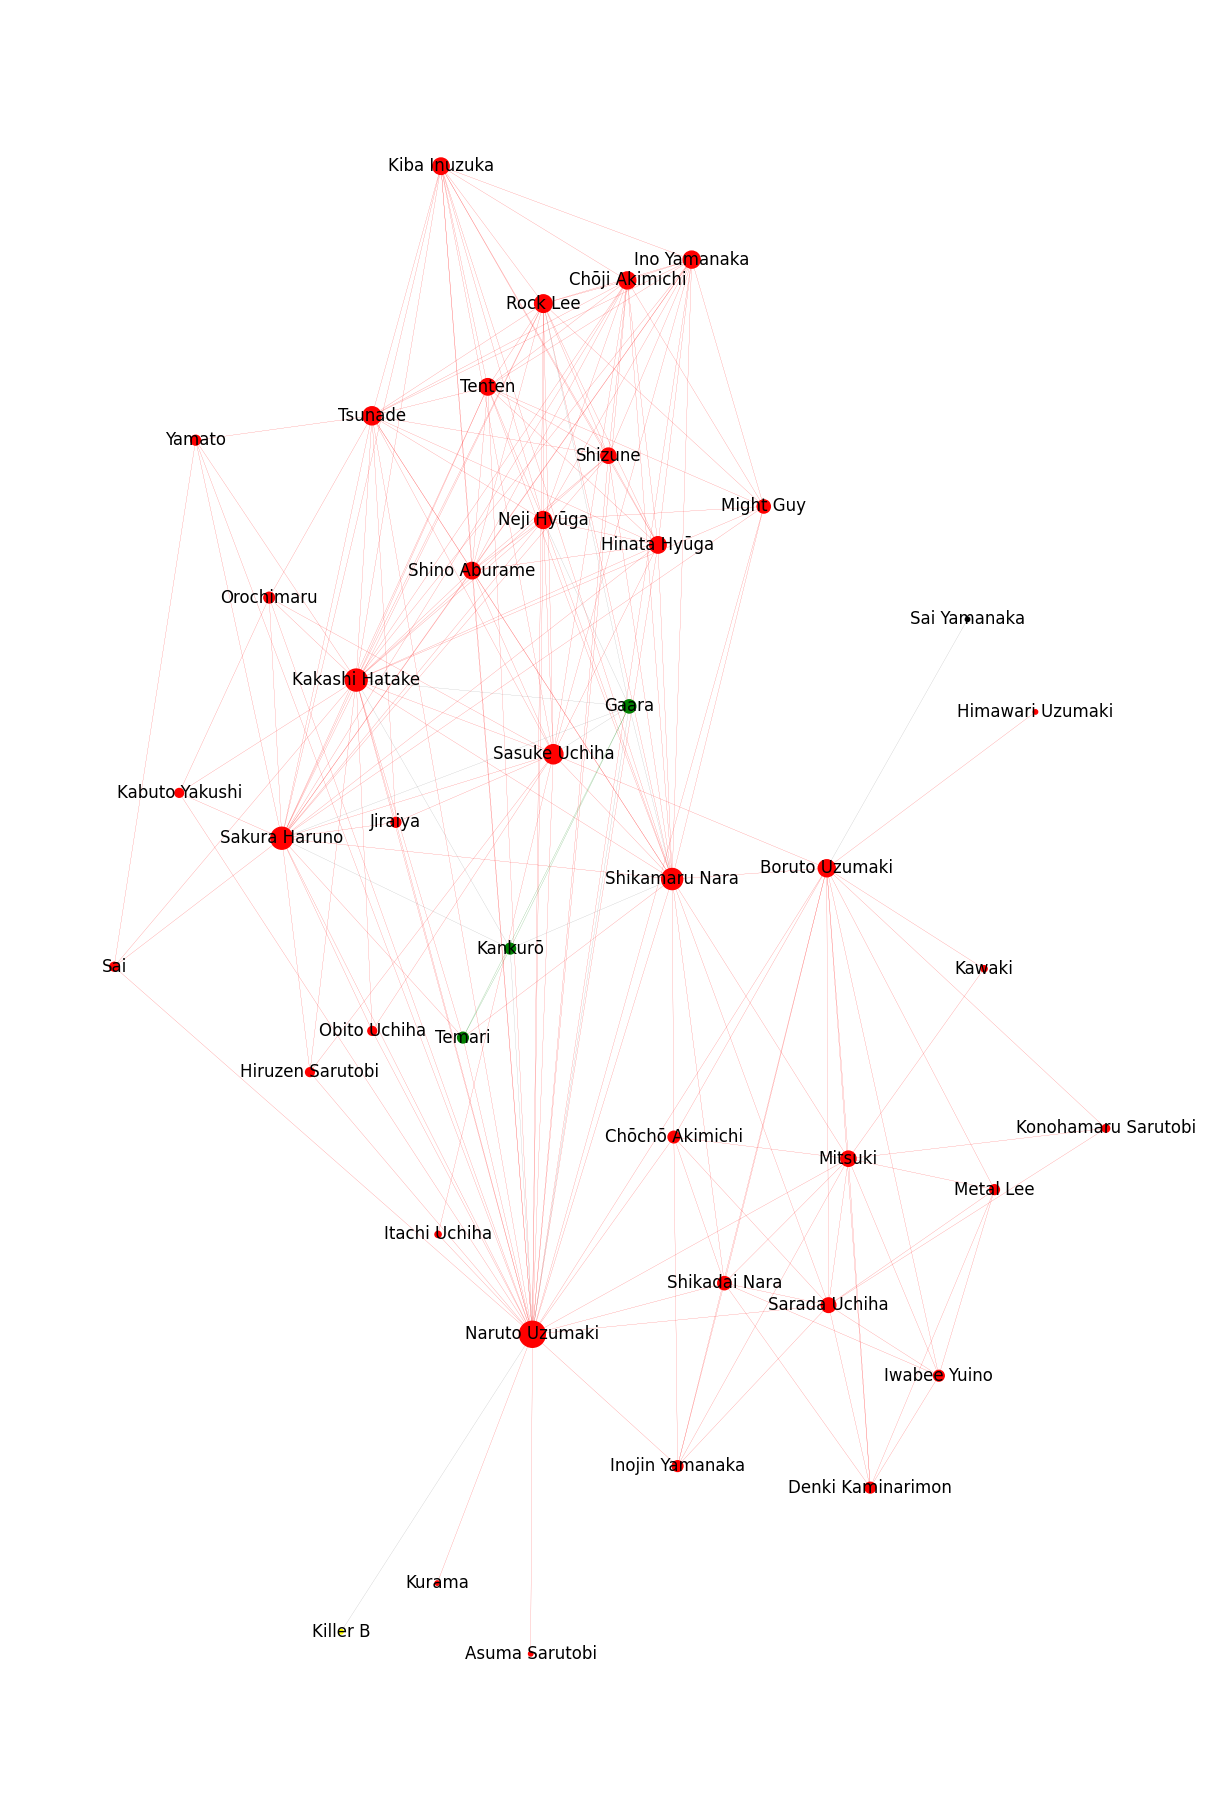

In [59]:
plot_graph(filtered_complete_graph['Min Co-occurence: 100'], layout='kamada-kawai')

#### Network of the Final Episode with a Minimum Co-Occurence Treshold: 200

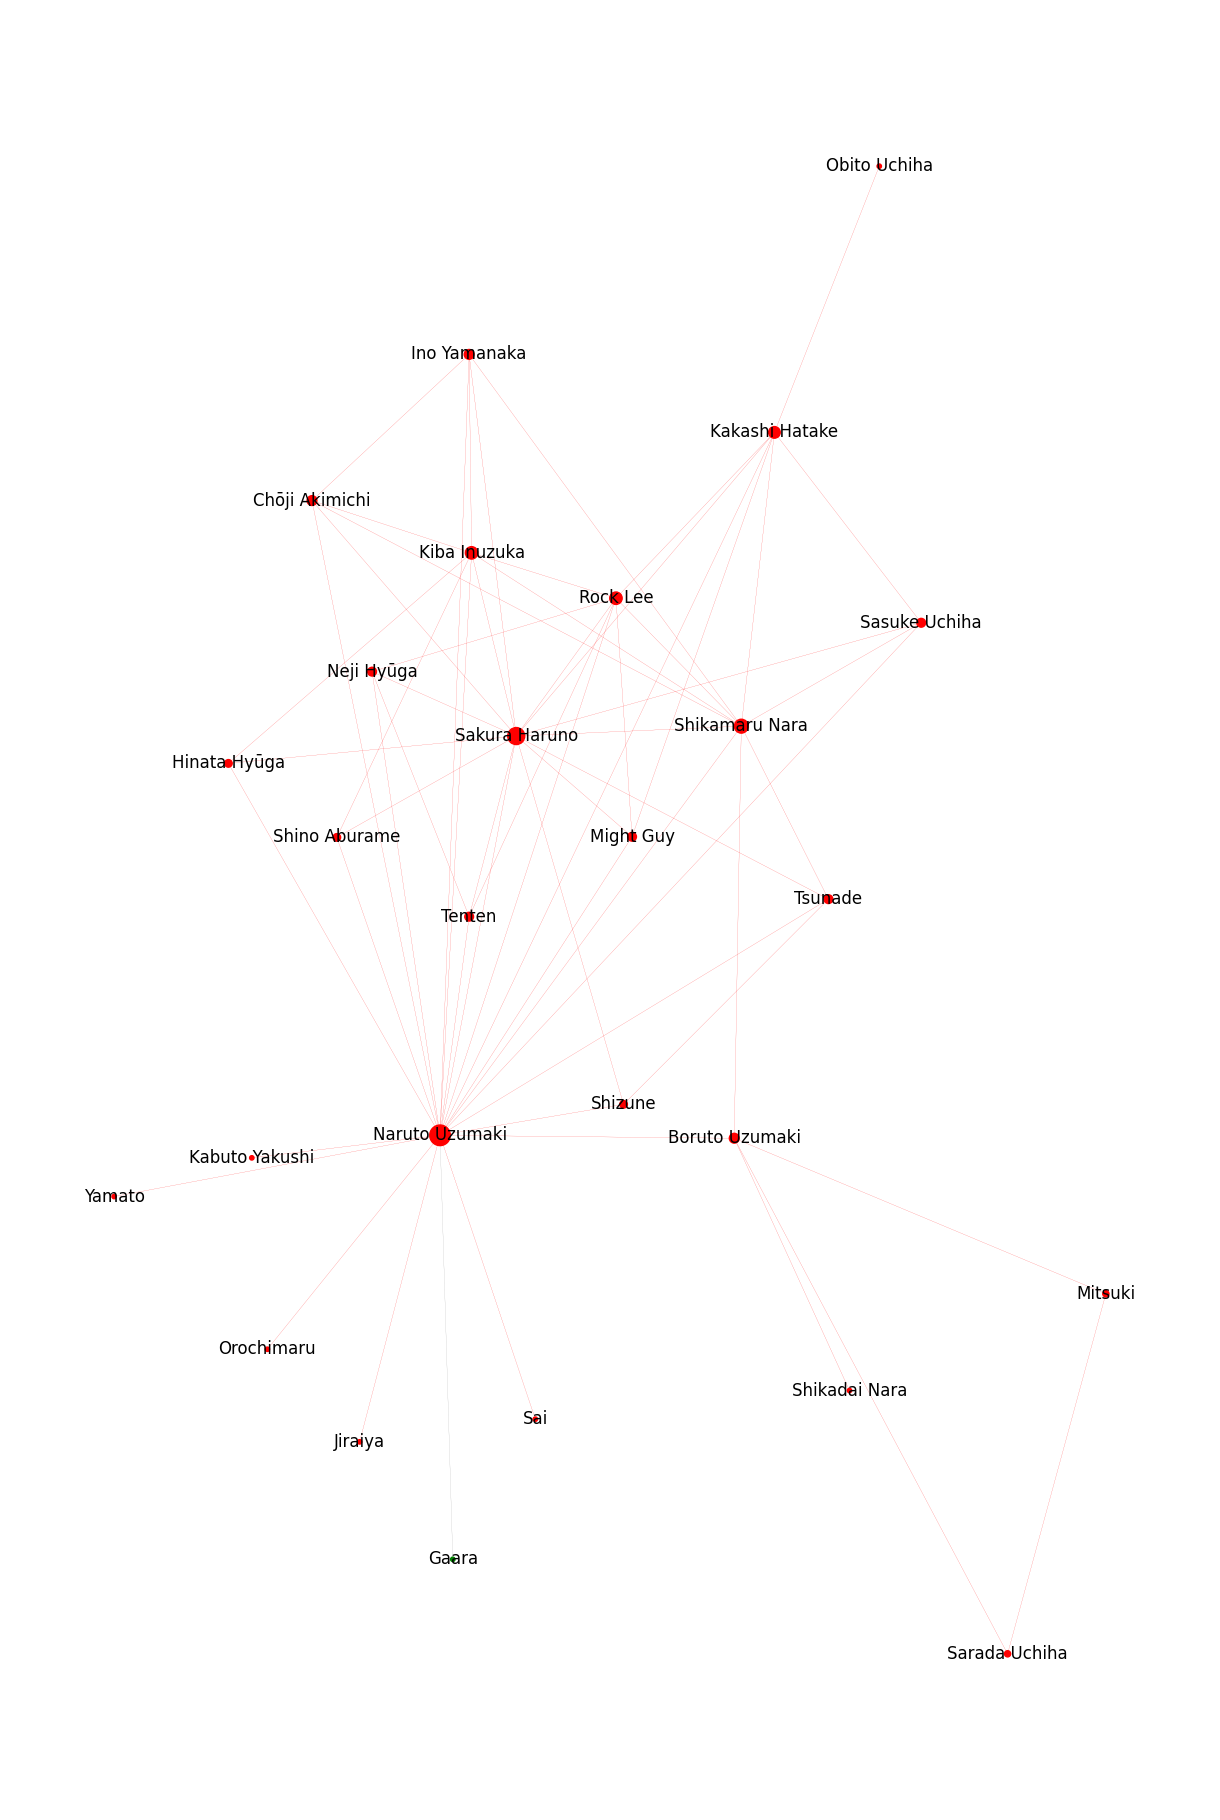

In [60]:
plot_graph(filtered_complete_graph['Min Co-occurence: 200'], layout='kamada-kawai')

#### Network of the Final Episode with a Minimum Co-Occurence Treshold: 500

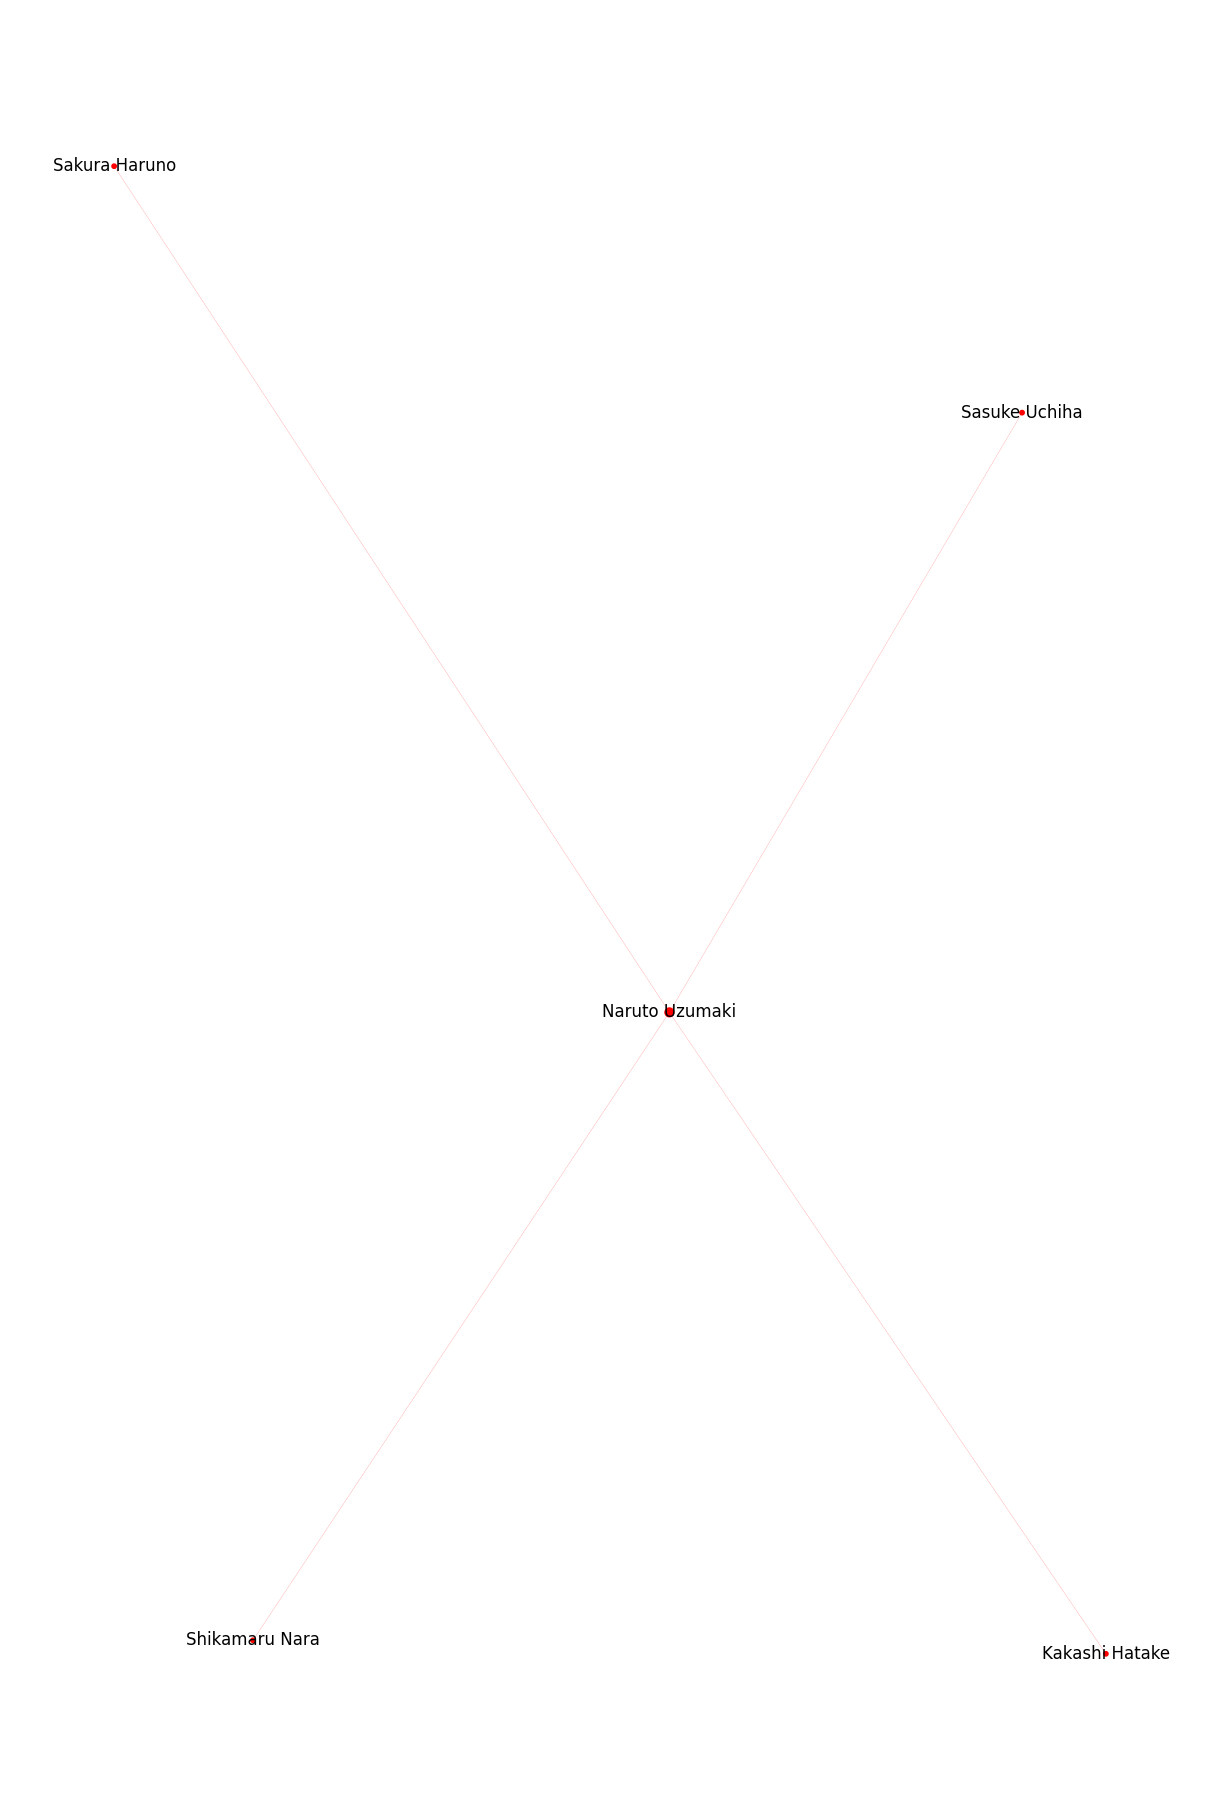

In [61]:
plot_graph(filtered_complete_graph['Min Co-occurence: 500'], layout='kamada-kawai')